# SpaceNet Rio Chip Classification Data Prep

This notebook prepares data for training a chip classification model on the Rio SpaceNet dataset.

* Set `raw_uri` to the local or S3 directory containing the raw dataset.
* Set `processed_uri` to a local or S3 directory (you can write to), which will store the processed data generated by this notebook.

This is all you will need to do in order to run this notebook.

In [1]:
raw_uri = 's3://spacenet-dataset/'
processed_uri = 's3://raster-vision-lf-dev/examples/spacenet/rio/processed-data/'
#processed_uri = '/opt/data/examples/spacenet/rio/processed-data'

The steps we'll take to make the data are as follows:

- Get the building labels and AOI (most likely from the SpaceNet AWS public dataset bucket)
- Use the AOI and the image bounds to determine which images can be used for training and validation
- Split the building labels by image, save a label GeoJSON file per image
- Split the labeled images into a training and validation set, using the percentage of the AOI each covers, aiming at an 80%/20% split.

This process will save the split label files, and `train_scenes.csv` and `val_scenes.csv` files that are used by the experiment at `experiments.spacenet.chip_classification`

In [2]:
import os
from os.path import join
import json
import tempfile

import boto3
import botocore
import rasterio
from shapely.geometry import (Polygon, shape)

import rastervision as rv
from rastervision.utils.files import (
    download_if_needed, list_paths, file_to_json, json_to_file, 
    get_local_path, make_dir, sync_to_dir, str_to_file)

## Get the label and AOI data from AWS's public dataset of Space Net

In [3]:
    label_uri = join(raw_uri, 'AOI_1_Rio/srcData/buildingLabels/Rio_Buildings_Public_AOI_v2.geojson')
aoi_uri = join(raw_uri, 'AOI_1_Rio/srcData/buildingLabels/Rio_OUTLINE_Public_AOI.geojson')

label_json = file_to_json(label_uri)
aoi_json = file_to_json(aoi_uri)

## Use the AOI to determine what images are inside the training set

Here we compare the AOI to the image extends to deteremine which images we can use for training and validation. We're using `rasterio`'s ability to read the metadata from raster data on S3 without downloading the whole image

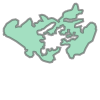

In [4]:
aoi = shape(aoi_json['features'][0]['geometry'])
aoi

In [5]:
images_uri = join(raw_uri, 'AOI_1_Rio/srcData/mosaic_3band')
image_paths = list_paths(images_uri)

In [6]:
def bounds_to_shape(bounds):
    return Polygon([[bounds.left, bounds.bottom],
                    [bounds.left, bounds.top],
                    [bounds.right, bounds.top],
                    [bounds.right, bounds.bottom],
                    [bounds.left, bounds.bottom]])

image_to_extents = {}
for img in image_paths:
    with rasterio.open(img, 'r') as ds:
        image_to_extents[img] = bounds_to_shape(ds.bounds)


In [7]:
intersecting_images = []
for img in image_to_extents:
    if image_to_extents[img].intersects(aoi):
        intersecting_images.append(img)

In [8]:
intersecting_images

['s3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022232021.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223131.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223133.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223130.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223132.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022232023.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022232022.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022232020.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022232200.tif',
 's3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223123.tif']

## Match labels to images

Find the labels that intersect with the image's bounding box, which will be saved into a labels geojson that matches the image name.

In [9]:
# Add a class_id and class_name to the properties of each feature
for feature in label_js['features']:
    feature['properties']['class_id'] = 1
    feature['properties']['class_name'] = 'building'

NameError: name 'label_js' is not defined

In [ ]:
image_to_features = {}
for img in intersecting_images:
    image_to_features[img] = []
    bbox = image_to_extents[img]
    for feature in label_js['features']:
        if shape(feature['geometry']).intersects(bbox):
            image_to_features[img].append(feature)
    

In [ ]:
processed_labels_uri = join(processed_uri, 'labels')

for img in image_to_features:
    fc = {}
    fc['type'] = 'FeatureCollection'
    fc['crs'] = label_js['crs']
    fc['features'] = image_to_features[img]
    img_id = os.path.splitext(os.path.basename(img))[0]
    label_path = join(processed_labels_uri, '{}.geojson'.format(img_id))
    json_to_file(fc, label_path)

## Split into train and validation

Split up training and validation data. There's an odd shaped AOI and not that many images, so we'll split the train and validation roughly based on how much area each scene covers of the AOI. 

Create a CSV that our experiments will use to load the training and validation data.



In [ ]:
# Split training and validation
ratio = 0.8
aoi_area = aoi.area
images_to_area = {}
for img in intersecting_images:
    area = image_to_extents[img].intersection(aoi).area
    images_to_area[img] = area / aoi_area

train_imgs = []
val_imgs = []
train_area_covered = 0
for img in sorted(intersecting_images, reverse=True, key=lambda img: images_to_area[img]):
    if train_area_covered < ratio:
        train_imgs.append(img)
        train_area_covered += images_to_area[img]
    else:
        val_imgs.append(img)
print("{} training images with {}% area.".format(len(train_imgs), train_area_covered))
print("{} validation images with {} area.".format(len(val_imgs), 1 - train_area_covered))

In [ ]:
def save_split_csv(imgs, path):
    csv_rows = []
    for img in imgs:
        img_id = os.path.splitext(os.path.basename(img))[0]
        img_path = join('srcData/mosaic_3band', '{}.tif'.format(img_id))
        label_path = join('labels','{}.geojson'.format(img_id))
        csv_rows.append('"{}","{}"'.format(img_path, label_path))
    str_to_file('\n'.join(csv_rows), path)
        
save_split_csv(train_imgs, join(processed_uri, 'train-scenes.csv'))
save_split_csv(val_imgs, join(processed_uri, 'val-scenes.csv'))